# Bell State Tomography via Parametric Compilation

Code and datasets for producing **Figure 7** from _A quantum-classical cloud platform optimized for variational hybrid algorithms_.

The `bell-state-tomography.csv` file contains QPU data from running **Bell state tomography** on Aspen-4, using _parametric compilation_ and pyQuil's `Experiment` framework. In addition, this notebook contains a section that walks through how to simulate these QPU results on a noisy QVM. The tools used below are the same ones used to collect the QPU data in the CSV file.

In [1]:
import itertools
from typing import Generator, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.cm import ScalarMappable
from matplotlib.colors import LinearSegmentedColormap, Normalize
from scipy.linalg import pinv

import pyquil.simulation.matrices as psm
from forest.benchmarking.distance_measures import fidelity
from forest.benchmarking.operator_tools.superoperator_transformations import unvec, vec
from forest.benchmarking.utils import all_traceless_pauli_terms
from pyquil import get_qc, Program
from pyquil.experiment import (
    Experiment, ExperimentResult, ExperimentSetting, correct_experiment_result, zeros_state
)
from pyquil.gates import CNOT, H, RESET
from pyquil.paulis import PauliTerm
from pyquil.simulation.tools import lifted_pauli

/Users/peter/.pyenv/versions/3.6.3/envs/qcs-36/lib/python3.6/site-packages/pyquil/gate_matrices.py:24: FutureWarning: The code in pyquil.gate_matrices has been moved to pyquil.simulation.matrices, please update your import statements.
  FutureWarning,


## Load the Data

In [2]:
df = pd.read_csv("datasets/bell-state-tomography.csv")

## Analyze the Data

### Build ideal density matrix for Bell state $|00\rangle + |11\rangle$

In [3]:
def build_rho_true() -> np.ndarray:
    """
    Generate the density matrix for state |00> + |11>.
    """
    psi00 = np.array([[1], [0], [0], [0]])
    bell00 = psm.CNOT @ np.kron(psm.H, psm.I) @ psi00
    return np.outer(bell00, bell00.T.conj())

rho_true = build_rho_true()
rho_true

array([[0.5, 0. , 0. , 0.5],
       [0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. ],
       [0.5, 0. , 0. , 0.5]])

### Estimate density matrix from QPU data using the linear inversion method

In [4]:
def linear_inversion_state_estimate(df: pd.DataFrame, qubits: List[int]) -> np.ndarray:
    """
    Adapted from forest.benchmarking.tomography.linear_inv_state_estimate,
    taking a pandas DataFrame instead of a List of ExperimentResult objects.
    """
    measurement_matrix = np.vstack([
        vec(lifted_pauli(PauliTerm.from_compact_str(setting.split('→')[-1]),
                         qubits=qubits)).T.conj() for setting in df.setting])
    rho = pinv(measurement_matrix) @ df.expectation
    dim = 2**len(qubits)
    return unvec(rho) + np.eye(dim) / dim

rho_estimated = linear_inversion_state_estimate(df, qubits=[0, 1])
np.round(rho_estimated, 3)

array([[ 0.513+0.j   ,  0.003-0.034j, -0.01 +0.002j,  0.502+0.01j ],
       [ 0.003+0.034j,  0.008+0.j   ,  0.004+0.009j,  0.012+0.027j],
       [-0.01 -0.002j,  0.004-0.009j,  0.009-0.j   , -0.028-0.003j],
       [ 0.502-0.01j ,  0.012-0.027j, -0.028+0.003j,  0.471+0.j   ]])

## Plot the Data

In [5]:
DARK_TEAL = "#47717d"
GOLD = "#f8ba2b"
LIGHT_TEAL = "#66acb4"
NAVY = "#00507b"

# build a custom colormap for the hinton plot
lsc = LinearSegmentedColormap.from_list(name="rigetti", colors=[NAVY, GOLD, LIGHT_TEAL, DARK_TEAL])
ANGLE_MAPPER = ScalarMappable(norm=Normalize(vmin=-np.pi, vmax=np.pi))
ANGLE_MAPPER.set_cmap(lsc)

def hinton(matrix: np.ndarray, ax: plt.Axes) -> None:
    """
    Adapted from forest.benchmarking.tomography.hinton to use custom colors.
    """
    max_weight=1.0
    ax.patch.set_facecolor("white")
    ax.set_aspect("equal", "box")
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())

    for (x, y), w in np.ndenumerate(matrix):
        color = np.arctan2(w.real, w.imag)
        color = ANGLE_MAPPER.to_rgba(color)
        size = np.sqrt(np.abs(w) / max_weight)
        rect = plt.Rectangle([x - size / 2, y - size / 2], size, size,
                             facecolor=color, edgecolor=color)
        ax.add_patch(rect)

    ax.set_xlim((-max_weight / 2, matrix.shape[0] - max_weight / 2))
    ax.set_ylim((-max_weight / 2, matrix.shape[1] - max_weight / 2))
    ax.autoscale_view()
    ax.invert_yaxis()

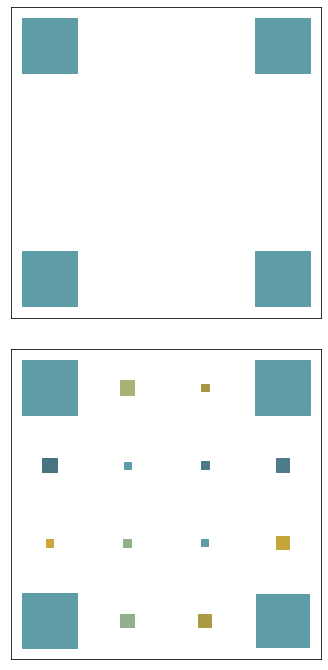

In [6]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(6, 12))
fig.subplots_adjust(hspace=0.1)
hinton(rho_true, ax=ax0)
hinton(rho_estimated, ax=ax1)

In [7]:
print(f"Estimated Bell state fidelity = {np.round(fidelity(rho_true, rho_estimated), 4)*100:.2f}%")

Estimated Bell state fidelity = 99.35%


## Simulate the Data on a Noisy QVM

In [8]:
qubits = (0, 1)
# fewer shots so it runs faster
shots = 500
qc = get_qc("2q-noisy-qvm")

### Define Bell state tomography `Experiment`

In [9]:
p = Program()
p += RESET()
p += H(qubits[0])
p += CNOT(qubits[0], qubits[1])
p.wrap_in_numshots_loop(shots)
print(p)

RESET
H 0
CNOT 0 1



In [10]:
def state_tomo_settings(qubits: List[int]) -> Generator[ExperimentSetting, None, None]:
    """
    Adapted from forest.benchmarking.tomography._state_tomo_settings,
    to use pyquil.experiment.ExperimentSetting objects instead.
    """
    list_of_terms = all_traceless_pauli_terms(qubits)
    for obs in all_traceless_pauli_terms(qubits):
        yield ExperimentSetting(
            in_state=zeros_state(qubits),
            out_operator=obs,
        )

In [11]:
state_tomography_settings = list(state_tomo_settings(qubits))
state_tomography_settings

[ExperimentSetting[Z0_0 * Z0_1→(1+0j)*X1],
 ExperimentSetting[Z0_0 * Z0_1→(1+0j)*Y1],
 ExperimentSetting[Z0_0 * Z0_1→(1+0j)*Z1],
 ExperimentSetting[Z0_0 * Z0_1→(1+0j)*X0],
 ExperimentSetting[Z0_0 * Z0_1→(1+0j)*X0X1],
 ExperimentSetting[Z0_0 * Z0_1→(1+0j)*X0Y1],
 ExperimentSetting[Z0_0 * Z0_1→(1+0j)*X0Z1],
 ExperimentSetting[Z0_0 * Z0_1→(1+0j)*Y0],
 ExperimentSetting[Z0_0 * Z0_1→(1+0j)*Y0X1],
 ExperimentSetting[Z0_0 * Z0_1→(1+0j)*Y0Y1],
 ExperimentSetting[Z0_0 * Z0_1→(1+0j)*Y0Z1],
 ExperimentSetting[Z0_0 * Z0_1→(1+0j)*Z0],
 ExperimentSetting[Z0_0 * Z0_1→(1+0j)*Z0X1],
 ExperimentSetting[Z0_0 * Z0_1→(1+0j)*Z0Y1],
 ExperimentSetting[Z0_0 * Z0_1→(1+0j)*Z0Z1]]

In [12]:
bell_state_tomography = Experiment(settings=state_tomography_settings, program=p)
bell_state_tomography

shots: 500
active reset: enabled
symmetrization: -1 (exhaustive)
calibration: 1 (plus_eigenstate)
program:
   H 0
   CNOT 0 1
settings:
   0: Z0_0 * Z0_1→(1+0j)*X1
   1: Z0_0 * Z0_1→(1+0j)*Y1
   2: Z0_0 * Z0_1→(1+0j)*Z1
   3: Z0_0 * Z0_1→(1+0j)*X0
   4: Z0_0 * Z0_1→(1+0j)*X0X1
   5: Z0_0 * Z0_1→(1+0j)*X0Y1
   6: Z0_0 * Z0_1→(1+0j)*X0Z1
   7: Z0_0 * Z0_1→(1+0j)*Y0
   8: Z0_0 * Z0_1→(1+0j)*Y0X1
   9: Z0_0 * Z0_1→(1+0j)*Y0Y1
   10: Z0_0 * Z0_1→(1+0j)*Y0Z1
   11: Z0_0 * Z0_1→(1+0j)*Z0
   12: Z0_0 * Z0_1→(1+0j)*Z0X1
   13: Z0_0 * Z0_1→(1+0j)*Z0Y1
   14: Z0_0 * Z0_1→(1+0j)*Z0Z1

### Collect data using readout symmetrization

In [13]:
%%time
results = qc.experiment(bell_state_tomography)
results

CPU times: user 2.07 s, sys: 106 ms, total: 2.17 s
Wall time: 3.79 s


[ExperimentResult[Z0_0 * Z0_1→(1+0j)*X1: -0.026 +- 0.03162790420379328],
 ExperimentResult[Z0_0 * Z0_1→(1+0j)*Y1: -0.02 +- 0.031632271505546365],
 ExperimentResult[Z0_0 * Z0_1→(1+0j)*Z1: 0.026 +- 0.03162790420379328],
 ExperimentResult[Z0_0 * Z0_1→(1+0j)*X0: 0.006 +- 0.031638030358493635],
 ExperimentResult[Z0_0 * Z0_1→(1+0j)*X0X1: 0.744 +- 0.014944687077216367],
 ExperimentResult[Z0_0 * Z0_1→(1+0j)*X0Y1: -0.007 +- 0.022365724061751344],
 ExperimentResult[Z0_0 * Z0_1→(1+0j)*X0Z1: 0.006 +- 0.022365869445609057],
 ExperimentResult[Z0_0 * Z0_1→(1+0j)*Y0: 0.028 +- 0.03162619509546186],
 ExperimentResult[Z0_0 * Z0_1→(1+0j)*Y0X1: 0.001 +- 0.022366260858990406],
 ExperimentResult[Z0_0 * Z0_1→(1+0j)*Y0Y1: -0.756 +- 0.014640326826433635],
 ExperimentResult[Z0_0 * Z0_1→(1+0j)*Y0Z1: 0.007 +- 0.022365724061751344],
 ExperimentResult[Z0_0 * Z0_1→(1+0j)*Z0: 0.024 +- 0.03162948662916338],
 ExperimentResult[Z0_0 * Z0_1→(1+0j)*Z0X1: -0.019 +- 0.02236223456561047],
 ExperimentResult[Z0_0 * Z0_1→(1+0j)*Z

### Perform readout calibration on all observables required for 2Q state tomography

In [14]:
%%time
calibrations = qc.calibrate(bell_state_tomography)
calibrations

CPU times: user 1.8 s, sys: 12.2 ms, total: 1.81 s
Wall time: 3.72 s


[ExperimentResult[X0_1→(1+0j)*X1: 0.894 +- 0.01417621123449298],
 ExperimentResult[Y0_1→(1+0j)*Y1: 0.874 +- 0.015374015752572924],
 ExperimentResult[Z0_1→(1+0j)*Z1: 0.874 +- 0.015374015752572924],
 ExperimentResult[X0_0→(1+0j)*X0: 0.888 +- 0.014548802963394196],
 ExperimentResult[X0_0 * X0_1→(1+0j)*X0X1: 0.79 +- 0.013712914424403203],
 ExperimentResult[X0_0 * Y0_1→(1+0j)*X0Y1: 0.775 +- 0.014134616857094091],
 ExperimentResult[X0_0 * Z0_1→(1+0j)*X0Z1: 0.784 +- 0.013884105451634113],
 ExperimentResult[Y0_0→(1+0j)*Y0: 0.884 +- 0.014790630911585981],
 ExperimentResult[Y0_0 * X0_1→(1+0j)*Y0X1: 0.814 +- 0.012991781756040944],
 ExperimentResult[Y0_0 * Y0_1→(1+0j)*Y0Y1: 0.749 +- 0.014819220784249292],
 ExperimentResult[Y0_0 * Z0_1→(1+0j)*Y0Z1: 0.766 +- 0.014377947095511951],
 ExperimentResult[Z0_0→(1+0j)*Z0: 0.874 +- 0.015374015752572924],
 ExperimentResult[Z0_0 * X0_1→(1+0j)*Z0X1: 0.75 +- 0.014793898394772671],
 ExperimentResult[Z0_0 * Y0_1→(1+0j)*Z0Y1: 0.788 +- 0.013770359886571694],
 Experi

### Correct for noisy readout using calibration results

In [15]:
results_corrected = []
for r, c in zip(results, calibrations):
    results_corrected.append(correct_experiment_result(r, c))
results_corrected

[ExperimentResult[Z0_0 * Z0_1→(1+0j)*X1: -0.029082774049217 +- 0.03538097453884937],
 ExperimentResult[Z0_0 * Z0_1→(1+0j)*Y1: -0.02288329519450801 +- 0.03619476866916767],
 ExperimentResult[Z0_0 * Z0_1→(1+0j)*Z1: 0.02974828375286041 +- 0.036191316654274705],
 ExperimentResult[Z0_0 * Z0_1→(1+0j)*X0: 0.006756756756756757 +- 0.03562858454575278],
 ExperimentResult[Z0_0 * Z0_1→(1+0j)*X0X1: 0.9417721518987341 +- 0.02500204946812061],
 ExperimentResult[Z0_0 * Z0_1→(1+0j)*X0Y1: -0.009032258064516128 +- 0.028859468945979374],
 ExperimentResult[Z0_0 * Z0_1→(1+0j)*X0Z1: 0.007653061224489796 +- 0.028528216638769834],
 ExperimentResult[Z0_0 * Z0_1→(1+0j)*Y0: 0.03167420814479638 +- 0.03578016372566333],
 ExperimentResult[Z0_0 * Z0_1→(1+0j)*Y0X1: 0.0012285012285012287 +- 0.027476985938103365],
 ExperimentResult[Z0_0 * Z0_1→(1+0j)*Y0Y1: -1.0093457943925235 +- 0.02794416771485223],
 ExperimentResult[Z0_0 * Z0_1→(1+0j)*Y0Z1: 0.009138381201044387 +- 0.02919857702091907],
 ExperimentResult[Z0_0 * Z0_1→(1

### Estimate density matrix from noisy QVM data using the linear inversion method

In [16]:
def linear_inv_state_estimate(results: List[ExperimentResult], qubits: List[int]) -> np.ndarray:
    """
    Adapted from forest.benchmarking.tomography.linear_inv_state_estimate,
    to use pyquil.experiment.ExperimentResult objects instead.
    """
    measurement_matrix = np.vstack([
        vec(lifted_pauli(result.setting.out_operator, qubits=qubits)).T.conj() for result in results])
    expectations = np.array([result.expectation for result in results])
    rho = pinv(measurement_matrix) @ expectations
    dim = 2**len(qubits)
    return unvec(rho) + np.eye(dim) / dim

rho_simulated = linear_inv_state_estimate(results_corrected, [0,1])
np.round(rho_simulated, 3)

array([[ 0.499+0.j   ,  0.004-0.01j , -0.014+0.012j,  0.488+0.002j],
       [ 0.004+0.01j ,  0.016-0.j   , -0.017+0.003j, -0.001-0.001j],
       [-0.014-0.012j, -0.017-0.003j,  0.015-0.j   , -0.   -0.006j],
       [ 0.488-0.002j, -0.001+0.001j, -0.   +0.006j,  0.471+0.j   ]])

### Plot the simulated data

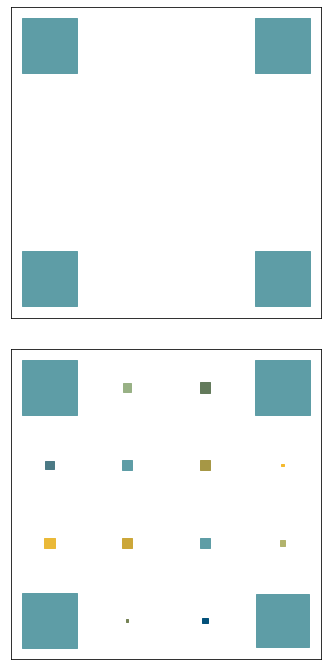

In [17]:
fig_qvm, (ax0_qvm, ax1_qvm) = plt.subplots(2, 1, figsize=(6, 12))
fig_qvm.subplots_adjust(hspace=0.1)
hinton(rho_true, ax=ax0_qvm)
hinton(rho_simulated, ax=ax1_qvm)

In [18]:
print(f"Simulated Bell state fidelity = {np.round(fidelity(rho_true, rho_simulated), 4)*100:.2f}%")

Simulated Bell state fidelity = 97.26%
